In [1]:
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, Y = datasets.load_iris(return_X_y=True)

In [3]:
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing

In [4]:
pca = decomposition.PCA()
pca.fit(X)

PCA()

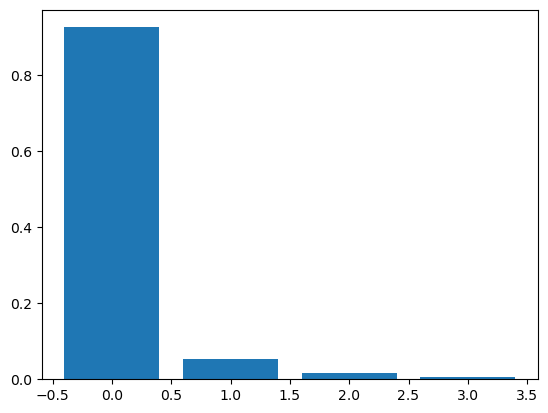

In [5]:
plt.bar(range(4), pca.explained_variance_ratio_)
plt.show()

In [6]:
U = pca.transform(X)
U = U[:,:2]

In [7]:
U2 = U[Y != 0]
Y2 = Y[Y != 0]

In [8]:
Y2[Y2 == 1] = -1
Y2[Y2 == 2] = +1

In [9]:
Y2 = Y2.astype('d')
N = len(Y2)

In [10]:
U2 = preprocessing.scale(U2)

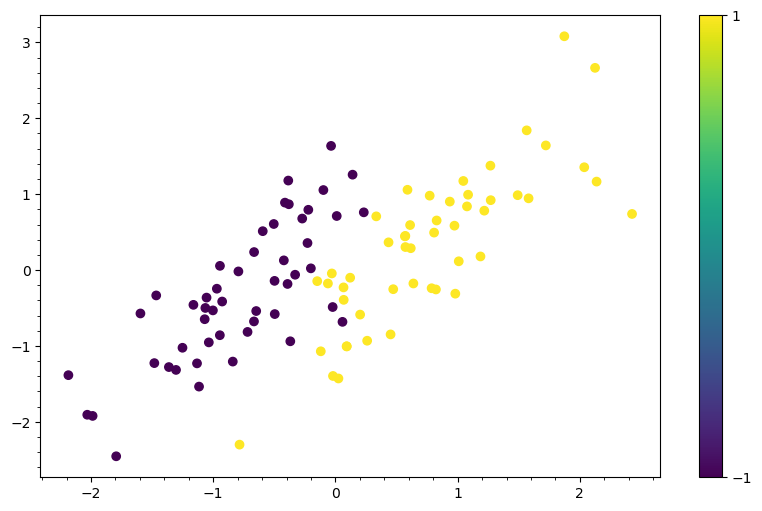

In [11]:
plt.figure(figsize=(10,6))
sc = plt.scatter(U2[:,0], U2[:,1], c=Y2)
plt.colorbar(sc,ticks=[-1,+1])
plt.minorticks_on()
plt.show()

In [12]:
import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.models as models
import mlgrad.funcs2 as funcs2
import mlgrad.regr as regr
import mlgrad.plots as plots
import mlgrad.inventory as inventory
import mlgrad.gd as gd

In [13]:
n_hidden1 = 201
# n_hidden2 = 101
# n_hidden3 = 101
body = models.FFNetworkModel()
ll = models.LinearLayer(2, n_hidden1)
ll.use_regularizer(funcs2.AbsoluteNorm(), 0.005)
body.add(ll)
body.add(models.ScaleLayer(funcs.Sigmoidal(7.0), n_hidden1))
# body.add(models.LinearLayer(n_hidden1, n_hidden2))
# body.add(models.ScaleLayer(funcs.Sigmoidal(4.0), n_hidden2))
# body.add(models.LinearLayer(n_hidden2, n_hidden3))
# body.add(models.ScaleLayer(funcs.Sigmoidal(4.0), n_hidden3))
head = models.LinearModel(body.n_output)
head.use_regularizer(funcs2.AbsoluteNorm(), 0.005)
nnmod = models.FFNetworkFuncModel(head, body)

In [14]:
nnmod.allocate()
nnmod.init_param()

In [15]:
print(len(nnmod.param))

805


In [16]:
alg = regr.regression(U2, Y2, nnmod,
                 loss_func=loss.MarginLoss(funcs.SoftHinge_Exp(5.0)),
                 # loss_func=loss.MarginLoss(funcs.SoftHinge_Sqrt(0.001)),
                 # normalizer=gd.Masked(nnmod.n_param, tol=1.0e-5),
                 # regnorm=funcs2.SoftAbsoluteNorm(0.0001), tau=2.0,
                 # regnorm=funcs2.SquareNorm(), tau=0.01,
                 h=0.001, n_restart=5)
inventory.normalize(nnmod.head.param)

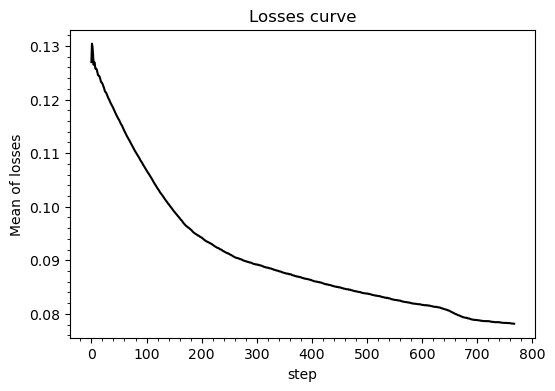

In [17]:
plots.plot_losses(alg)
plt.show()

In [18]:
def calc_zz(mod, min_val, max_val):
    xrange = np.linspace(min_val, max_val, 201)
    yrange = np.linspace(min_val, max_val, 201)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = mod.evaluate(XY)
    ZZ = ZZ.reshape(XX.shape)
    return ZZ

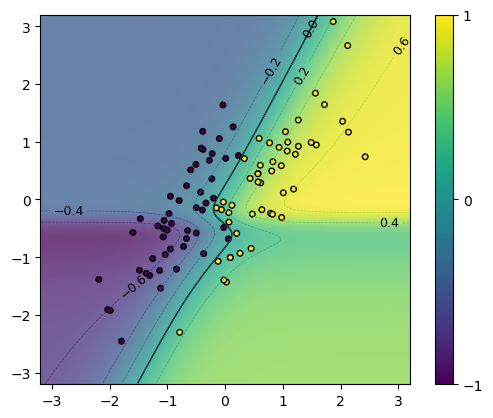

In [19]:
ZZ = calc_zz(nnmod, -3.2, 3.2)
# plt.figure(figsize=(12,4))
cs = plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=16)
plt.imshow(ZZ, origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), alpha=0.75)
plt.colorbar(cs, ticks=[-1,0,1])
plt.contour(ZZ, levels=[0], origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=1, colors='k')
cn = plt.contour(ZZ, origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=0.5, linestyles='--')
plt.clabel(cn, colors='k', fontsize=9)
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.show()

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
accuracy_score(Y2, np.sign(nnmod.evaluate(U2)))

1.0

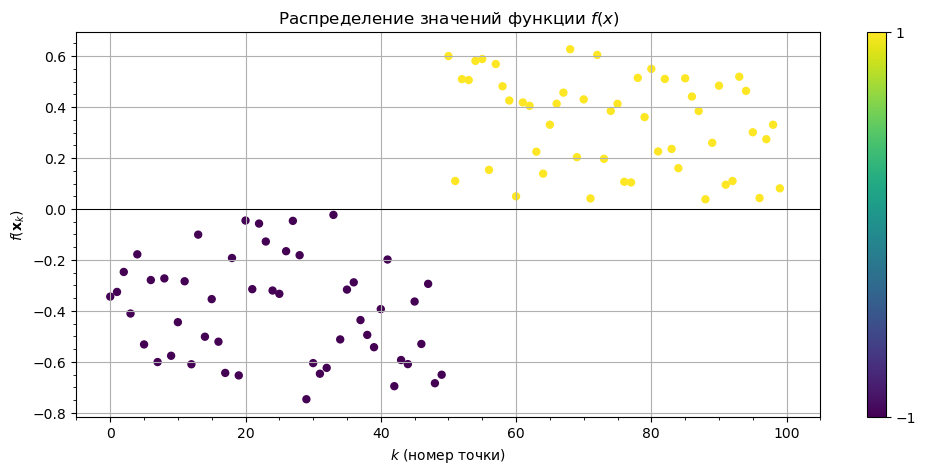

In [22]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(nnmod, U2, Y2)
plt.show()

In [23]:
P0 = np.asarray(nnmod.head.param)
P = np.asarray(nnmod.body.param)

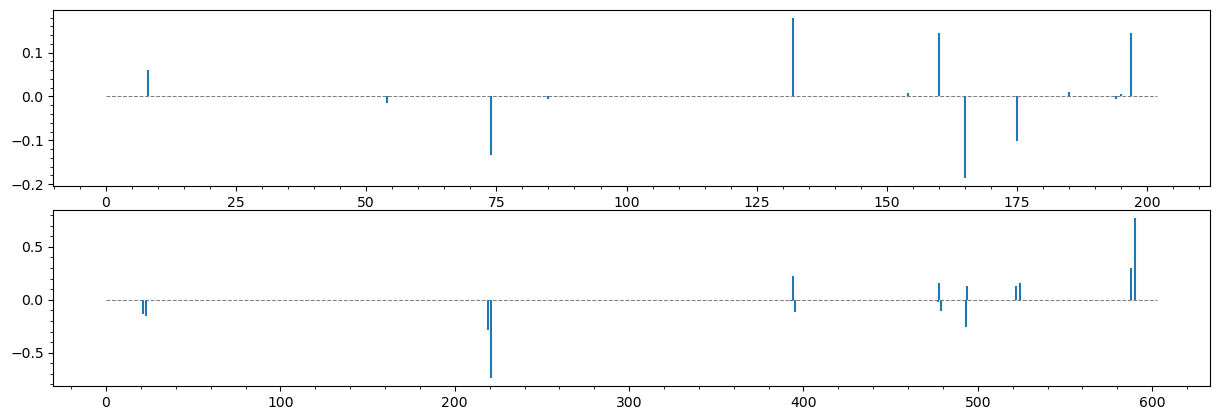

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plots.plot_array_vlines(P0)
plt.subplot(2,1,2)
plots.plot_array_vlines(P)
plt.minorticks_on()
plt.tight_layout(pad=0)
plt.show()